# Tache de generation de titre pour des articles. 

The dataset for Title Generation comprises a collection of articles along with their corresponding titles and subjects. Each entry in the dataset includes the full text of an article, its subject category, and the title that summarizes its content. This batchset serves as a valuable resource for natural language processing tasks, particularly in the domain of text summarization and headline generation. Researchers, developers, and enthusiasts can leverage this batchset to train machine learning models for automatic title generation, headline summarization, and related applications. With a diverse range of subjects and article texts, this batchset offers ample opportunities for experimentation and innovation in the field of natural language processing.

link : https://www.kaggle.com/datasets/thejas2002/titlegen

## Chargement des modules, des données et visualisations

In [32]:
import numpy as np
import pandas as pd 
from pandas import DataFrame

import os
import re
import tqdm
import multiprocessing
from pathlib import Path

from datetime import datetime 
import kagglehub

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from IPython.display import display, HTML


import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.tensorboard import SummaryWriter

from datasets import Dataset

# Importing the T5 modules from huggingface/transformers
from transformers import AutoTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer


from torch import cuda

# Load the ROUGE metric
import evaluate



# link nootbooks associated : 
# https://www.kaggle.com/code/thejas2002/title-generation
# https://www.kaggle.com/code/a3amat02/news-title-generation-using-t5

# https://medium.com/nlplanet/a-full-guide-to-finetuning-t5-for-text2text-and-building-a-demo-with-streamlit-c72009631887
# https://learnopencv.com/fine-tuning-t5/
# https://github.com/Shivanandroy/T5-Finetuning-PyTorch


## Configuration

In [2]:

device = 'cuda' if cuda.is_available() else 'cpu'

SEED = 0  # random seed 

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(SEED) # pytorch random seed
np.random.seed(SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

MAX_LEN_TEXT = 512
MAX_LEN_TITLE = 45
MIN_LEN_TITLE = 3

MODEL_TYPE = "t5"
MODEL_NAME = "t5-small"

NUM_PROCS = os.cpu_count() #print(NUM_PROCS)

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 6

NUM_BEAMS=4

LEARNING_RATE = 1e-4

NB_EPOCHS = 15



## Load dataset from Kaggle

In [3]:
os.makedirs("../data/tp2/titlegen",exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("thejas2002/titlegen",force_download=True)

for dirname, _, filenames in os.walk(path):
    print(dirname)
    print(_)
    print(filenames)
    for filename in filenames:
        Path(os.path.join(dirname, filename)).rename(os.path.join("../data/tp2/titlegen", filename))

100%|██████████| 13.3M/13.3M [00:00<00:00, 14.9MB/s]

Extracting files...


/home/ivanhoe/.cache/kagglehub/datasets/thejas2002/titlegen/versions/2
[]
['train.csv', 'test.csv']


In [4]:
! file "../data/tp2/titlegen/train.csv"

../data/tp2/titlegen/train.csv: CSV text


In [4]:
path_df = os.path.join("../data/tp2/titlegen", "train.csv")

encoding='utf-8'

# Load training batch
try:
    df = pd.read_csv(path_df,encoding=encoding)
    df.dropna(inplace=True)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading Dataset: {e}")

#Avoir moins de données -> A commenter par la suite
df = df.sample(int(df.shape[0]*0.2))

train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
eval_df, test_df = train_test_split(test_df, test_size=0.5,random_state=0)

print(train_df.info())
print(eval_df.info())
print(test_df.info())


Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
Index: 2398 entries, 5906 to 5741
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    2398 non-null   object
 1   text     2398 non-null   object
 2   subject  2398 non-null   object
 3   date     2398 non-null   object
dtypes: object(4)
memory usage: 93.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 7436 to 431
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    300 non-null    object
 1   text     300 non-null    object
 2   subject  300 non-null    object
 3   date     300 non-null    object
dtypes: object(4)
memory usage: 11.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 300 entries, 10952 to 10218
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    300 non-null    object
 1   text    

## Question 1 : 
- Reprendre la fonction "display_random_sample" vu au tp1 pour visualiser les données

In [5]:


def display_random_sample(dataset:DataFrame, num_examples:int=1)->None:

    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset." # A way to raise an error if it's not true
    sample_df = dataset.sample(num_examples)

    display(HTML(sample_df.to_html()))

display_random_sample(train_df,3) 

,title,text,subject,date
1338,"NuStar's St. Eustatius terminal damaged by Irma, no restart date set","HOUSTON (Reuters) - Nustar Energy s oil terminal in the Caribbean island of St. Eustatius suffered damage to several tanks and other equipment due to Hurricane Irma, but all the U.S. firm s employees are safe and no oil spills were registered, it said in a statement. NuStar s Statia terminal has the capacity to store 13.03 million barrels of crude and products. The company also said that no restart date has yet been set, and that it will be working on Thursday to restore power at the facility. Despite the damage and major clean-up effort, we feel like we fared very well considering the significant power of this storm, it said.",worldnews,"September 7, 2017"
13290,Chile's leftists stop short of endorsing presidential candidate Guillier,"SANTIAGO (Reuters) - A coalition of Chilean leftist parties on Thursday challenged presidential contender Alejandro Guillier to clarify his social and economic policies, withholding the outright endorsement sought by the center-left candidate. Beatriz Sanchez, the flagbearer for the hard-left Frente Amplio coalition, also criticized conservative ex-president Sebastian Pinera, the frontrunner, and called him a step back for the country, in a statement issued after a party meeting. Pinera and Guillier will face off in a Dec. 17 runoff vote after placing first and second respectively in the first round of the election on Nov. 19. Sanchez, who campaigned on a promise to tax mining companies and the super-rich in order to boost social spending, finished just two percentage points behind Guillier. Her stronger-than-anticipated performance spooked markets and ensured the bloc will have influence, both in Congress and over campaigning for the second round. We are not the owners of anyone s vote, so we call on our supporters to make their voices heard in this second round, and to vote according to their own convictions and analysis, Sanchez said on national television. She challenged Guillier to clarify his positions on her bloc s priorities, including overhauling the country s highly privatized pension system, forgiving the student loans of university graduates and re-writing Chile s dictatorship-era constitution. This isn t about negotiating with us. It s about negotiating with those who overwhelmingly support these changes in our society, she said. Guillier did not immediately respond to the demands of the Frente Amplio. But winning over Sanchez s 1.3 million voters is seen by Guillier s camp as essential in triumphing over Pinera. Guillier said at a campaign event on Monday that he would need everyone s support to advance. He has offered to forgive the debt of 40 percent of the country s poorest university students and said he remained open to rewriting Chile s constitution, both policies intended to appeal to leftist voters. But Guillier must walk a fine line, as a too-sharp turn to the left could push more moderate voters - historically a large and potent voting bloc in Chile - to Pinera. Both candidates would keep in place the top copper exporter s longstanding free-market economic model, but Pinera has promised investor-friendly policies to turbocharge growth, while Guillier wants to press on with outgoing President Michelle Bachelet s overhaul of education, taxes and labor laws.",worldnews,"November 30, 2017"
14822,Russia to the United States: Stay in Iran nuclear deal,"UNITED NATIONS (Reuters) - Russia s U.N. ambassador, Vassily Nebenzia, said Moscow s message to the United States during a likely meeting of the parties to the Iran nuclear deal next week on the sidelines to the United Nations General Assembly was to stay in the deal. That is not only our message, but the rest of the participants and those that are outside are trying to send this message across, Nebenzia told reporters on Friday.",worldnews,"September 15, 2017"


## Question 2 :
- Charger le tokenizer associé au modèle T5-Small, afficher ensuite la taille du vocabulaire, les tokens spéciaux et le nombre maximal de tokens à fournir au model.
- Etudier la normalisation et les sorties associés au tokenizer


In [6]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME,clean_up_tokenization_spaces=True,legacy=False)
#print(tokenizer)
print(tokenizer.vocab_size)
print(tokenizer.pad_token, tokenizer.pad_token_id)
print(tokenizer.eos_token,tokenizer.eos_token_id)
print(tokenizer.unk_token,tokenizer.unk_token_id)
print(tokenizer.model_max_length)


32100
<pad> 0
</s> 1
<unk> 2
512


In [7]:
text = """BRUSSELS/KIEV (Reuters)
 - Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU
 leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West,
   officials say. url : http://univangers  caractères spéciaux : $=)&)ç,à_ué  balise html :<p>EU membership ambitions<p/> </s>
"""

print(tokenizer.backend_tokenizer.normalizer.normalize_str(text))

print(tokenizer.tokenize(text))

source = tokenizer(text,return_tensors='pt')

print(source["input_ids"].squeeze(),source["attention_mask"].squeeze())


BRUSSELS/KIEV (Reuters)  - Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU  leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West,    officials say. url : http://univangers  caractères spéciaux : $=)&)ç,à_ué  balise html :<p>EU membership ambitions<p/> </s> 
['▁', 'BR', 'US', 'SEL', 'S', '/', 'KI', 'EV', '▁(', 'Reuters', ')', '▁', '-', '▁Ukraine', '▁', 's', '▁EU', '▁membership', '▁ambition', 's', '▁will', '▁coll', 'ide', '▁with', '▁the', '▁West', '▁', 's', '▁reform', '▁demands', '▁at', '▁', 'a', '▁summit', '▁on', '▁Friday', '▁with', '▁EU', '▁leaders', '▁ready', '▁to', '▁', 'a', 'd', 'mon', 'ish', '▁Kiev', '▁for', '▁failing', '▁to', '▁implement', '▁anti', '-', 'co', 'rruption', '▁laws', '▁that', '▁would', '▁bring', '▁it', '▁closer', '▁to', '▁the', '▁West', ',', '▁officials', '▁say', '.', '▁', 'url', '▁', ':', '▁http', '://', 'un', 'iva', 'nger', 's', '▁caractère', 's

## Question 3 :
- Proposer une fonction "clean_text" qui normalise les articles selon vos critères de pertinence.



Détails de l'expression régulière :

^ : L'accent circonflexe signifie le début de la ligne ou de la chaîne de caractères.

. : Cela représente n'importe quel caractère (sauf les sauts de ligne).
flags=re.DOTALL : Le paramètre flags=re.DOTALL permet à l'opérateur . de correspondre à n'importe quel caractère, y compris les sauts de ligne

\* : Cela signifie "0 ou plusieurs occurrences" du caractère précédent (ici, n'importe quel caractère).

? : C'est un modificateur appelé "lazy matching" ou "non-greedy". Cela signifie qu'il va capturer le minimum possible de caractères, contrairement à un quantificateur * sans ? qui capte le maximum possible.

In [8]:
import re   

def clean_text(text):
   
   # Remove any text before and including a hyphen followed by a space
   text = re.sub(r'^.*?- ', '', text, flags=re.DOTALL) 

   # Remove URLs (e.g., "Visit https://example.com" -> "Visit")
   text = re.sub(r'http*?://\S+|www\.\S+', '', text)

   # Remove HTML tags (e.g., "<p>text</p>" -> "text")
   text = re.sub(r'<.*?>+', '', text)

   #Remove extra space
   text = ' '.join(text.split())

   # Remove newline characters (e.g., "text\nmore text" -> "text more text")
   text = re.sub(r'\n', '', text)

   return text

# Example usage of the function
result = clean_text(text)

print(result)  

Ukraine s EU membership ambitions will collide with the West s reform demands at a summit on Friday with EU leaders ready to admonish Kiev for failing to implement anti-corruption laws that would bring it closer to the West, officials say. url : caractères spéciaux : $=)&)ç,à_ué balise html :EU membership ambitions


## Question 4 :
- Le modèle T5 est un modèle "text to text", l'ajout d'un contexte ou d'une consigne permet de guider la génération du modèle. Ajouter un prompte pour la génération de titre. -> "Generate a title: " pour effectuer une demande spécifique au modèle T5 

In [9]:
train_df["text"] = "Generate a title: " + train_df["text"].apply(clean_text)
eval_df["text"] = "Generate a title: "  + eval_df["text"].apply(clean_text)
test_df["text"] = "Generate a title: " + test_df["text"].apply(clean_text)

train_df = train_df[["text","title"]]

eval_df = eval_df[["text","title"]]

test_df = test_df[["text","title"]]

In [10]:
display_random_sample(train_df,3) 

,text,title
3471,"Generate a title: Chinese President Xi Jinping said on Thursday China will be more open and transparent to foreign companies, including those from the United States. U.S. companies are also welcome to take part in China s Belt and Road initiative, Xi told a briefing in Beijing after talks with U.S. President Donald Trump. China s door to the world will only open wider, he said.","Xi says China to be more open, transparent to foreign companies including America's"
7252,"Generate a title: Iraq s parliament voted on Tuesday on a formula to halt financial transactions with the Kurdistan region, in retaliation for last week s independence referendum, Iraqi State TV said, without specifying if vote was binding on the government. The formula would preserve the interests of Kurdish citizens, the channel said, hinting that the measures would target the Kurdish leadership. The channel gave no further details.",Iraq parliament votes to halt transactions with Kurdistan: state TV
7637,"Generate a title: Britain accused Russia on Thursday of carrying out a thinly veiled political attack on the head of the world s chemical weapons watchdog, escalating a row over the agency s investigation into toxic attacks in Syria. The comments, made during a session at the Hague-based Organisation for the Prohibition of Chemical Weapons (OPCW), were the latest sign of deep political division at the body over the Syrian conflict. In an Oct. 26 report the U.N.-OPCW investigation team blamed the Syrian government for an April 4 attack using the banned nerve agent sarin in the opposition-held town of Khan Sheikhoun, killing around 80 people. The Syrian government has denied using chemical weapons and Moscow rejected the findings. The mechanism was established in 2015 by the U.N. Security Council to identify individuals, organizations or governments responsible for chemical attacks in Syria. Its mandate expires on Nov. 17, but its work is incomplete. Moscow is poised to veto efforts by Britain, France, Germany and the United States to extend the mandate. U.S. representative Kenneth Ward told delegates at a meeting of the OPCW s 41-member executive council that they were fighting for the future of the Chemical Weapons Convention, the watchdog s founding treaty. There can be no doubt that since 2013, Syria has engaged in a grotesque and calculated campaign of chemical weapons use, he said. Russia continues to deny the truth and, instead, collaborates with the Assad regime. A draft Russian-Iranian proposal circulated at the OPCW and seen by Reuters called for a new investigation, to be based on samples taken from the attack site. The Syrian government itself has already presented samples from the scene to the investigation team, which tested positive for sarin. It is a thinly veiled political attack on the professional integrity of the director general, the British delegation said in a statement, referring to the OPCW s outgoing Turkish head, Ahmet Uzumcu. It seeks to undermine the capability and competence of the (OPCW). The Russian delegation at the OPCW could not be reached for comment. Syria joined the OPCW after a sarin attack on Aug. 21, 2013, killed hundreds of people in Ghouta, a district on the outskirts of Damascus. It has said it declared and destroyed all its chemical stockpile, but chemical attacks continue in the country s civil war.","Britain, Russia clash over Syria at chemical weapons body"


## Question 5 :
- Proposer une visualisation du nombre moyen de tokens par article dans le jeu de données. 

In [56]:
text_input_ids_train = train_df["text"].apply(lambda text : len(tokenizer(text, truncation=False,return_tensors='pt')["input_ids"].squeeze()) )

title_input_ids_train = train_df["title"].apply(lambda title : len(tokenizer(title, truncation=False,return_tensors='pt')["input_ids"].squeeze()) )

Token indices sequence length is longer than the specified maximum sequence length for this model (725 > 512). Running this sequence through the model will result in indexing errors


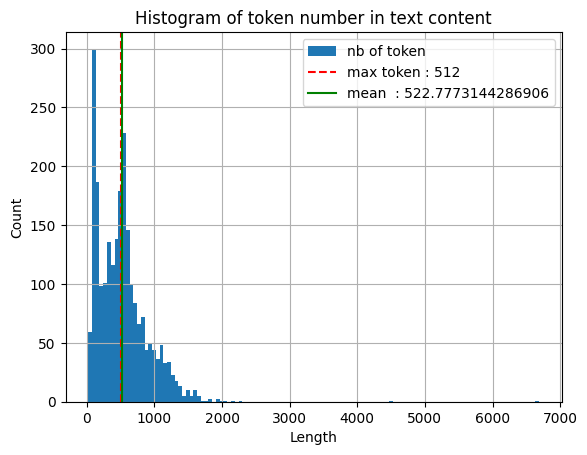

0.46371976647206004 % des texts avec plus de 512 tokens


In [57]:
text_input_ids_train.hist(bins=120,label='nb of token')

# Add a vertical line at x=512 with red color
plt.axvline(x=512, color='r', linestyle='--', label='max token : 512')
plt.axvline(x=text_input_ids_train.mean(), color='g', linestyle='-', label=f'mean  : {text_input_ids_train.mean()}')

# Adding title and labels 
plt.title('Histogram of token number in text content') 
plt.xlabel('Length') 
plt.ylabel('Count') 
plt.legend()
  
# Display the histogram 
plt.show() 

print(f"{text_input_ids_train[text_input_ids_train > 512].count()/text_input_ids_train.count()} % des texts avec plus de 512 tokens")

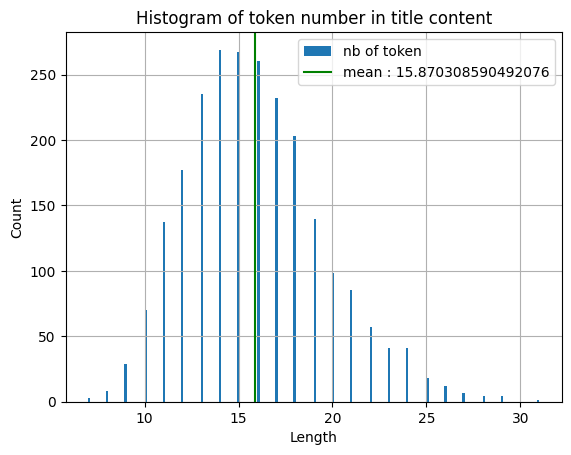

In [58]:
title_input_ids_train.hist(bins=200,label='nb of token')

# Add a vertical line at x=512 with red color
plt.axvline(x=title_input_ids_train.mean() , color='g', linestyle='-', label=f'mean : {title_input_ids_train.mean()}')

# Adding title and labels 
plt.title('Histogram of token number in title content') 
plt.xlabel('Length') 
plt.ylabel('Count') 
plt.legend()
  
# Display the histogram 
plt.show() 


## Dataset Pipeline preprocessing

### Question 6 : 

* Construire des datasets train, eval et test avec la classe Dataset. 

* Ajout des colonnes 'input_ids', 'attention_mask', 'labels', 'labels_mask' avec la méthode map et une fonction "tokenize_function"

* Construire des dataloaders associés qui rajoutent le padding pour chaque batch.

In [11]:
#transforme a pandas df to a torch dataset object 
train_dataset = Dataset.from_pandas(train_df)
eval_dataset = Dataset.from_pandas(eval_df)
test_dataset = Dataset.from_pandas(test_df)


In [12]:
# Define a function for tokenization
def tokenize_function(example,truncation=True):

    source = tokenizer(text=example["text"], truncation=truncation, max_length=MAX_LEN_TEXT, return_tensors='pt')
    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    
   
    target = tokenizer(text_target=example["title"], truncation=truncation, max_length=MAX_LEN_TITLE, return_tensors='pt')
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'input_ids': source_ids, 
        'attention_mask': source_mask,
        'labels': target_ids, 
        'labels_mask': target_mask
        }

In [13]:
train_dataset = train_dataset.map(tokenize_function,num_proc=NUM_PROCS)
eval_dataset = eval_dataset.map(tokenize_function,num_proc=NUM_PROCS)
test_dataset = test_dataset.map(tokenize_function,num_proc=NUM_PROCS)


Map (num_proc=12): 100%|██████████| 300/300 [00:00<00:00, 869.92 examples/s] 


In [14]:
# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function that add padding for each batch.
    """

    # Pad the tokenized content
    padded_text_ids = pad_sequence(
        [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)
    
    padded_text_mask = pad_sequence(
        [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=0)

    padded_title_ids = pad_sequence(
        [torch.tensor(item['labels'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)     
    
    padded_title_mask = pad_sequence(
        [torch.tensor(item['labels_mask'], 
                      dtype=torch.long) for item in batch], 
                      batch_first=True, 
                      padding_value=0)
    

    return {
        'input_ids':padded_text_ids,
        'attention_mask':padded_text_mask,
        'labels':padded_title_ids,
        'labels_mask':padded_title_mask
    }


In [15]:

train_params = {
    'batch_size': TRAIN_BATCH_SIZE,
    'shuffle': True,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

val_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

# This will be used down for training and validation stage for the model.
train_loader = DataLoader(train_dataset, **train_params)
eval_loader = DataLoader(eval_dataset, **val_params)
test_loader = DataLoader(test_dataset, **val_params)

In [17]:
for batch in train_loader:
    for key in batch.keys():
        print(key)
        print(batch[key].shape)

    break

for batch in eval_loader:
    for key in batch.keys():
        print(batch[key])
    break

input_ids
torch.Size([4, 512])
attention_mask
torch.Size([4, 512])
labels
torch.Size([4, 22])
labels_mask
torch.Size([4, 22])
tensor([[ 6939,  2206,     3,  ...,     9,  1401,     1],
        [ 6939,  2206,     3,  ...,     7,    91,     1],
        [ 6939,  2206,     3,  ...,     0,     0,     0],
        [ 6939,  2206,     3,  ..., 10678,    53,     1],
        [ 6939,  2206,     3,  ...,    56, 17540,     1],
        [ 6939,  2206,     3,  ...,     0,     0,     0]])
tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 1, 1, 1],
        [1, 1, 1,  ..., 0, 0, 0]])
tensor([[   86,   166,   719,     6,  2523, 11872,     7,  5139,    78,   412,
             5,   567,     5,    54,   942,   423,  1055,     1],
        [ 4066,    18,   509, 27599, 14837,  4792,    57,  1450,  6417,    16,
         21384,     1,     0,     0,     0,     0,     0,     0],
        [ 7819, 16735,  4640, 

## Chargement du modèle T5

## Question 7 :
- Charger le modèle T5-small pré-entrainé avec une tête de décodage pour la génération de contenu "T5ForConditionalGeneration". 

- Étudier l'architecture du model chargé et affichier le nombre de paramètres 

- Tester le model sur les données sans entrainement pour la tâche de génération de titre. Évaluer la qualité des réponses, utiliser la métric "ROUGE" pour afficher un score sur les données test. 

In [18]:
# Further this model is sent to device (GPU/TPU) for using the hardware.
t5_model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
t5_model = t5_model.to(device)

# Total parameters and trainable parameters.
total_params = sum(p.numel() for p in t5_model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(p.numel() for p in t5_model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

60,506,624 total parameters.
60,506,624 training parameters.


In [67]:
print(t5_model)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

### Tester le model sur les données alétaoires :

In [19]:
text, title = train_df.sample()[["text","title"]].values[0]

print(text,'\n\n')

inputs = [text]

inputs = tokenizer(inputs, max_length=515, truncation=True, return_tensors="pt")

with torch.no_grad():
    t5_model.eval()
    output = t5_model.generate(**inputs.to(device), num_beams=NUM_BEAMS, do_sample=True, min_length=MIN_LEN_TITLE, max_length=MAX_LEN_TITLE)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]


    print("Generate title: " , decoded_output,"\n\n")
    print("Expected title: " , title)


Generate a title: Greece and Turkey squared up over old disputes on Thursday during a state visit to Athens by President Tayyip Erdogan that quickly descended into verbal sparring over a list of historical grievances. Designed to boost relations between the two nations, the first visit of a Turkish president in 65 years quickly turned into a blunt grudge-fest between the NATO allies. The two countries agreed to revive a consultation process for confidence-building measures, Prime Minister Alexis Tsipras said. By the end of the first day, both sides appeared to pull back from what threatened to be a massive diplomatic flop. There is a lot more which unites us, from that which divides us, as long as there is will, Greek President Prokopis Pavlopoulos told a state banquet in Erdogan s honor. We can live side by side, Erdogan said in a translation provided by Greek state TV. Our aim is to build the future differently, with unity, coexistence and solidarity, he said. Earlier, he and Erdogan

### Rouge métrique

In [20]:
rouge = evaluate.load('rouge')
candidates = ["Summarization is cool","I love Machine Learning","Good night"]

references = ["Summarization is beneficial and cool","I think i love Machine Learning","Good night everyone!"]
             
results = rouge.compute(predictions=candidates, references=references)
print(results)

{'rouge1': 0.7833333333333332, 'rouge2': 0.5833333333333334, 'rougeL': 0.7833333333333332, 'rougeLsum': 0.7833333333333332}


In [73]:
t5_model.eval()

rouge1_score, rouge2_score = 0, 0

with torch.no_grad():
    
    for _, batch in tqdm.tqdm(enumerate(eval_loader, 0),desc=f'total iter: {len(eval_loader)}', unit=" iter"):
        y_ids = batch["labels"]
        y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)

        #print(y_txt)

        ###ENCODER input
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        #print(ids.size(),mask.size())
        
        generated_ids = t5_model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TITLE, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )   
        #print(generated_ids)

        generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        #print(generated_txt)

        # Compute ROUGE scores here
        rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
        rouge1_score += rouge_results['rouge1']
        rouge2_score += rouge_results['rouge2']
        

print(rouge1_score/(len(eval_loader)*VALID_BATCH_SIZE))
print(rouge2_score/(len(eval_loader)*VALID_BATCH_SIZE))

total iter: 50: 50 iter [05:51,  7.03s/ iter]

0.03894645866762816
0.01194770379798255


# Entrainer les poids du modèle et sauvegarder la meilleures version du code

## Question 8 : 
- Compléter la fonction main ci-dessous pour lancer l'entrainement des poids du modèle à la tâche de génération de titre :

    *  https://www.kaggle.com/code/fadyelkbeer/train-t5-model-from-scratch

In [29]:

def train(tokenizer, model, device, loader, optimizer, epoch, writer):
    """
    Function to call for training with the parameters passed from main function
    
    """

    rouge1_score, rouge2_score = 0, 0
    total_loss = 0.0

    model.train()

    for _, batch in tqdm.tqdm(enumerate(loader, 0),desc=f'Total iterations: {len(loader)}', unit=" it"):

        y_ids = batch["labels"].to(device, dtype=torch.long).contiguous()

        labels = y_ids.clone().detach()
        labels[labels == tokenizer.pad_token_id] = -100 # ignore index pour la cross entropie

        decoder_input_ids = model._shift_right(y_ids)
        decoder_attention_mask = batch["labels_mask"].to(device, dtype=torch.long).contiguous()

        ids = batch["input_ids"].to(device, dtype=torch.long)
        mask = batch["attention_mask"].to(device, dtype=torch.long)

        outputs = model(
            input_ids=ids,
            attention_mask=mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask = decoder_attention_mask,
            labels=labels
        )


        loss = outputs[0]
        total_loss += loss.item()
        
        writer.add_scalar(f"batch_loss/train", loss/len(batch), epoch*len(loader) + _ )

        if _ % 15 == 0:
            y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)
            
            generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TEXT, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
            generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
            #print(generated_txt)

            # Compute ROUGE scores here
            rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
            rouge1_score += rouge_results['rouge1']
            rouge2_score += rouge_results['rouge2']

            writer.add_scalar(f"batch_rouge1/train", rouge_results['rouge1'], epoch*len(loader) + _ )
            writer.add_scalar(f"batch_rouge2/train", rouge_results['rouge2'], epoch*len(loader) + _ )
            #print(rouge_results)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return {"loss": total_loss/len(loader) , "rouge1":rouge1_score/len(loader), "rouge2":rouge2_score/len(loader)} 

In [30]:

def eval(tokenizer, model, device, loader): #epoch,writer 

    """
    Function to be called for evaluate with the parameters passed from main function

    """
    rouge1_score, rouge2_score = 0, 0
    total_loss = 0.0

    model.eval()
    with torch.no_grad():
        for _, batch in tqdm.tqdm(enumerate(loader, 0),desc=f'Total iterations: {len(loader)}', unit=" it"):
            y_ids = batch["labels"].to(device, dtype=torch.long).contiguous()

            labels = y_ids.clone().detach()
            labels[labels == tokenizer.pad_token_id] = -100 # ignore index pour la cross entropie

            decoder_input_ids = model._shift_right(y_ids)
            decoder_attention_mask = batch["labels_mask"].to(device, dtype=torch.long).contiguous()

            ids = batch["input_ids"].to(device, dtype=torch.long)
            mask = batch["attention_mask"].to(device, dtype=torch.long)

            outputs = model(
                input_ids=ids,
                attention_mask=mask,
                decoder_input_ids=decoder_input_ids,
                decoder_attention_mask = decoder_attention_mask,
                labels=labels
            )


            loss = outputs[0]
            total_loss += loss.item()
                
            #writer.add_scalar(f"batch_loss/eval", loss/len(batch), epoch*len(loader) + _ )

            if _ % 15 == 0:
                y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)
                
                generated_ids = model.generate(
                    input_ids = ids,
                    attention_mask = mask, 
                    max_length=MAX_LEN_TEXT, 
                    num_beams=NUM_BEAMS,
                    repetition_penalty=2.5, 
                    length_penalty=1.0, 
                    early_stopping=True
                )
                generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)
                #print(generated_txt)

                # Compute ROUGE scores here
                rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
                rouge1_score += rouge_results['rouge1']
                rouge2_score += rouge_results['rouge2']

                #writer.add_scalar(f"batch_rouge1/eval", rouge_results['rouge1'], epoch*len(loader) + _ )
                #writer.add_scalar(f"batch_rouge2/eval", rouge_results['rouge2'], epoch*len(loader) + _ )
                #print(rouge_results)
                

    return {"loss": total_loss/len(loader) , "rouge1":rouge1_score/len(loader), "rouge2":rouge2_score/len(loader)} 

In [31]:
# Initialisation
time = datetime.now().strftime("%Y-%m-%d_%Hh%M")

checkpoint_path = f"../models_checkpoints/tp2/T5_small_tuned_{time}"
os.makedirs(checkpoint_path,exist_ok=True)

log_dir = f"./logs/tp2/T5_small_tuned_{time}" 
os.makedirs(log_dir,exist_ok=True)

writer = SummaryWriter(log_dir=log_dir)

# Defining the optimizer that will be used to tune the weights of the network in the training session. 
optimizer = torch.optim.Adam(params =  t5_model.parameters(), lr=LEARNING_RATE)

early_stopping_patience = 5
reduce_lr_patience = 2
reduce_lr_factor = 0.1

scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                patience=reduce_lr_patience,
                                factor=reduce_lr_factor)


In [33]:
def main(tokenizer, model, device, train_loader, eval_loader, optimizer, writer, scheduler, checkpoint_path, NB_EPOCHS):
        
    best_loss = float('inf')
    patience_counter = 0
    current_lr = 0

    eval_loss, train_loss = [], []
    
    for epoch in range(NB_EPOCHS):
        outputs_train = train(tokenizer, model, device, train_loader, optimizer, epoch, writer)
        outputs_eval = eval(tokenizer, model, device, eval_loader)
        
        train_loss.append(outputs_train["loss"])
        eval_loss.append(outputs_eval["loss"])

        writer.add_scalars("loss",{"train":outputs_train["loss"], "eval":outputs_eval["loss"] } , epoch)
        writer.add_scalars("rouge1",{"train":outputs_train["rouge1"], "eval":outputs_eval["rouge1"] } , epoch)
        writer.add_scalars("rouge2",{"train":outputs_train["rouge2"], "eval":outputs_eval["rouge2"] } , epoch)


        # Enregistrer le taux d'apprentissage actuel
        for param_group in optimizer.param_groups:
            current_lr = param_group['lr']
            writer.add_scalar("lr", current_lr, epoch)

        # Réduit automatiquement le taux d'apprentissage si la perte de validation ne diminue pas
        # sous les critères
        scheduler.step(eval_loss[-1])

        # Early Stopping
        if eval_loss[-1] < best_loss:
            best_loss = eval_loss[-1]
            patience_counter = 0
            # Sauvegarder le meilleur modèle
            model.save_pretrained(checkpoint_path)
            tokenizer.save_pretrained(checkpoint_path)
            epoch_best = epoch+1
            print(f'Find a better model at the epoch {epoch+1} - Train Loss: {train_loss[-1]:.4f}, eval Loss: {eval_loss[-1]:.4f}')
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping triggered")
                print("current_lr : ", current_lr)
                print("epoch_best : ", epoch_best)
                break

        writer.close()

In [34]:
main(tokenizer, t5_model, device, train_loader, eval_loader, optimizer, writer,scheduler,checkpoint_path, NB_EPOCHS)

Total iterations: 600: 600 it [04:39,  2.15 it/s] epoch/s]
Total iterations: 50: 50 it [00:12,  3.98 it/s]
Total epochs: 1: 100%|██████████| 1/1 [04:52<00:00, 292.45s/ epoch]

Find a better model at the epoch 1 - Train Loss: 2.4985, eval Loss: 2.1773


# Chargement du model, utilisation et evaluation sur des données tests

## Question 9 : 
- Vérifier que vous pouvez charger votre modèle "finetuné" et évaluer ses performance sur le jeu de données test avec la métrique rouge. 
- Transférer votre modèle sur la plateforme "Huggingface" pour le rendre opensource. 
 

## Configuaration pour un restart après entrainement

In [25]:
import numpy as np
import pandas as pd 
from pandas import DataFrame

import os
import re
import tqdm 
import multiprocessing
from pathlib import Path

from datetime import datetime 
import kagglehub

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence


from datasets import Dataset

# Importing the T5 modules from huggingface/transformers
from transformers import AutoTokenizer
from transformers import T5ForConditionalGeneration, T5Tokenizer


from torch import cuda

# Load the ROUGE metric
import evaluate


from huggingface_hub import HfApi, HfFolder, whoami



# link nootbooks associated : 
# https://www.kaggle.com/code/thejas2002/title-generation
# https://www.kaggle.com/code/a3amat02/news-title-generation-using-t5

# https://medium.com/nlplanet/a-full-guide-to-finetuning-t5-for-text2text-and-building-a-demo-with-streamlit-c72009631887
# https://learnopencv.com/fine-tuning-t5/
# https://github.com/Shivanandroy/T5-Finetuning-PyTorch


In [26]:

device = 'cuda' if cuda.is_available() else 'cpu'

SEED = 0  # random seed 

# Set random seeds and deterministic pytorch for reproducibility
torch.manual_seed(SEED) # pytorch random seed
np.random.seed(SEED) # numpy random seed
torch.backends.cudnn.deterministic = True

MAX_LEN_TEXT = 512
MAX_LEN_TITLE = 45
MIN_LEN_TITLE = 3

MODEL_TYPE = "t5"
MODEL_NAME = "t5-small"

NUM_PROCS = os.cpu_count() #print(NUM_PROCS)

TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 6

NUM_BEAMS=4

rouge = evaluate.load('rouge')


In [27]:
path_df = os.path.join("../data/tp2/titlegen", "train.csv")

encoding='utf-8'

# Load training batch
try:
    df = pd.read_csv(path_df,encoding=encoding)
    df.dropna(inplace=True)
    print("Dataset loaded successfully.")
except Exception as e:
    print(f"Error loading Dataset: {e}")

#Avoir moins de données -> A commenter par la suite
df = df.sample(int(df.shape[0]*0.2))

train_df, test_df = train_test_split(df, test_size=0.2,random_state=0)
eval_df, test_df = train_test_split(test_df, test_size=0.5,random_state=0)

del train_df, eval_df

def clean_text(text):
   
   # Remove any text before and including a hyphen followed by a space
   text = re.sub(r'^.*?- ', '', text, flags=re.DOTALL) 

   # Remove URLs (e.g., "Visit https://example.com" -> "Visit")
   text = re.sub(r'http*?://\S+|www\.\S+', '', text)

   # Remove HTML tags (e.g., "<p>text</p>" -> "text")
   text = re.sub(r'<.*?>+', '', text)

   #Remove extra space
   text = ' '.join(text.split())

   # Remove newline characters (e.g., "text\nmore text" -> "text more text")
   text = re.sub(r'\n', '', text)

   return text

test_df["text"] = "Generate a title: " + test_df["text"].apply(clean_text)

test_df = test_df[["text","title"]]

#transforme a pandas df to a torch dataset object 
test_dataset = Dataset.from_pandas(test_df)



Dataset loaded successfully.


In [28]:

best_weight_path = '../models_checkpoints/tp2/T5_small_tuned_2025-02-03_11h19'

# Load the model and tokenizer
my_t5_model = T5ForConditionalGeneration.from_pretrained(best_weight_path)
tokenizer = AutoTokenizer.from_pretrained(best_weight_path,clean_up_tokenization_spaces=True,legacy=False)

# Move the model to the desired device
my_t5_model = my_t5_model.to(device)


In [29]:
# Define a function for tokenization
def tokenize_function(example,truncation=True):

    source = tokenizer(text=example["text"], truncation=truncation, max_length=MAX_LEN_TEXT, return_tensors='pt')
    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    
   
    target = tokenizer(text_target=example["title"], truncation=truncation, max_length=MAX_LEN_TITLE, return_tensors='pt')
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'input_ids': source_ids, 
        'attention_mask': source_mask,
        'labels': target_ids, 
        'labels_mask': target_mask
        }

test_dataset = test_dataset.map(tokenize_function,num_proc=NUM_PROCS)

Map (num_proc=12):   0%|          | 0/300 [00:00<?, ? examples/s]

In [30]:
# Define the custom collate function
def collate_fn(batch):
    """
    Custom collate function that add padding for each batch.
    """

    # Pad the tokenized content
    padded_text_ids = pad_sequence(
        [torch.tensor(item['input_ids'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)
    
    padded_text_mask = pad_sequence(
        [torch.tensor(item['attention_mask'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=0)

    padded_title_ids = pad_sequence(
        [torch.tensor(item['labels'], dtype=torch.long) for item in batch], 
        batch_first=True, 
        padding_value=tokenizer.pad_token_id)     
    
    padded_title_mask = pad_sequence(
        [torch.tensor(item['labels_mask'], 
                      dtype=torch.long) for item in batch], 
                      batch_first=True, 
                      padding_value=0)
    

    return {
        'input_ids':padded_text_ids,
        'attention_mask':padded_text_mask,
        'labels':padded_title_ids,
        'labels_mask':padded_title_mask
    }

test_params = {
    'batch_size': VALID_BATCH_SIZE,
    'shuffle': False,
    'collate_fn':collate_fn,
    'num_workers': NUM_PROCS
    }

test_loader = DataLoader(test_dataset, **test_params)

## Réponses à la question 9 

In [22]:
my_t5_model.eval()

rouge1_score, rouge2_score = 0, 0

with torch.no_grad():
    
    for _, batch in tqdm.tqdm(enumerate(test_loader, 0),desc=f'total iter: {len(test_loader)}', unit=" iter"):
        y_ids = batch["labels"]
        y_txt = tokenizer.batch_decode(y_ids, skip_special_tokens=True)

        #print(y_txt)

        ###ENCODER input
        ids = batch["input_ids"].to(device)
        mask = batch["attention_mask"].to(device)
        #print(ids.size(),mask.size())
        
        generated_ids = my_t5_model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=MAX_LEN_TITLE, 
              num_beams=NUM_BEAMS,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )   
        #print(generated_ids)

        generated_txt = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

        #print(generated_txt)

        # Compute ROUGE scores here
        rouge_results = rouge.compute(predictions=generated_txt, references=y_txt)
        rouge1_score += rouge_results['rouge1']
        rouge2_score += rouge_results['rouge2']
        

print(rouge1_score/(len(test_loader)*VALID_BATCH_SIZE))
print(rouge2_score/(len(test_loader)*VALID_BATCH_SIZE))

total iter: 50: 50 iter [03:12,  3.85s/ iter]

0.07258716628239985
0.03506990586196233


In [31]:
text, title = test_df.sample()[["text","title"]].values[0]

print(text,'\n\n')

inputs = [text]

inputs = tokenizer(inputs, max_length=515, truncation=True, return_tensors="pt")

with torch.no_grad():
    my_t5_model.eval()
    output = my_t5_model.generate(**inputs.to(device), num_beams=NUM_BEAMS, do_sample=True, min_length=MIN_LEN_TITLE, max_length=MAX_LEN_TITLE)
    decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)[0]


    print("Generate title: " , decoded_output,"\n\n")
    print("Expected title: " , title)


Generate a title: A majority of Americans disagree with President Donald Trump’s assertion that football players should be fired for kneeling during the national anthem, even though most say they would personally stand during the song, according to an exclusive Reuters/Ipsos opinion poll released on Tuesday. The Sept. 25-26 poll found that 57 percent of adults do not think the National Football League should fire players who kneel. This included 61 percent of NFL fans who watch at least a few games per season. The results were split along party lines, however, as 82 percent of Democrats and 29 percent of Republicans disagreed with the president’s comments about firing football players. For poll results, see: tmsnrt.rs/2y6pxBk Trump waded into the issue last week at a political rally when he bemoaned what he saw as a decline in the sport. Among other things, Trump criticized players who want to draw attention to what they believe is social and racial injustice by refusing to stand durin

### Upload le model sur Huggingface et le récupérer
* https://huggingface.co/docs/huggingface_hub/en/quick-start
* https://huggingface.co/docs/timm/hf_hub

In [ ]:
# Récupérer le token depuis les variables d’environnement
hf_token = os.getenv("LABO_HF_WRITE_TOKEN")

# Vérifier si le token est bien récupéré
if hf_token:
    print("Token récupéré avec succès.")
    HfFolder.save_token(hf_token)
    print(whoami(token=hf_token))
else:
    print("Erreur : le token n’a pas été trouvé.")

api = HfApi()

Token récupéré avec succès.
{'type': 'user', 'id': '6602ca685b27612b271e286f', 'name': 'Ivanhoe9', 'fullname': 'Botcazou', 'email': 'ibotca52@gmail.com', 'emailVerified': True, 'canPay': False, 'periodEnd': None, 'isPro': False, 'avatarUrl': 'https://cdn-avatars.huggingface.co/v1/production/uploads/noauth/rEeDTQYYrwVAUUkdjZAJ1.png', 'orgs': [], 'auth': {'type': 'access_token', 'accessToken': {'displayName': 'labo_huggingface_write_token', 'role': 'write', 'createdAt': '2025-02-03T10:10:13.010Z'}}}


In [36]:
api.upload_folder(
    folder_path=best_weight_path,
    repo_id="Ivanhoe9/finetune_T5_small_title_generation_NLP_cours",
    repo_type="model",
)

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Ivanhoe9/finetune_T5_small_title_generation_NLP_cours/commit/55918657d2326dcfa2702d78ddc96aa1ee6e86b1', commit_message='Upload folder using huggingface_hub', commit_description='', oid='55918657d2326dcfa2702d78ddc96aa1ee6e86b1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Ivanhoe9/finetune_T5_small_title_generation_NLP_cours', endpoint='https://huggingface.co', repo_type='model', repo_id='Ivanhoe9/finetune_T5_small_title_generation_NLP_cours'), pr_revision=None, pr_num=None)

### load le model sur Huggingface et le récupérer
* https://huggingface.co/docs/timm/hf_hub

In [ ]:
# Load the model and tokenizer
my_t5_model_hf = T5ForConditionalGeneration.from_pretrained("Ivanhoe9/finetune_T5_small_title_generation_NLP_cours")
tokenizer_hf = AutoTokenizer.from_pretrained("Ivanhoe9/finetune_T5_small_title_generation_NLP_cours",clean_up_tokenization_spaces=True,legacy=False)

# Move the model to the desired device
my_t5_model_hf.to(device)

This article is about the latest technological innovations in the field of AI


In [42]:
text, title = test_df.sample()[["text","title"]].values[0]

print(text,'\n\n')

inputs = [text]

inputs = tokenizer_hf(inputs, max_length=515, truncation=True, return_tensors="pt")

with torch.no_grad():
    my_t5_model_hf.eval()
    output = my_t5_model_hf.generate(**inputs.to(device), num_beams=NUM_BEAMS, do_sample=True, min_length=MIN_LEN_TITLE, max_length=MAX_LEN_TITLE)
    decoded_output = tokenizer_hf.batch_decode(output, skip_special_tokens=True)[0]


    print("Generate title: " , decoded_output,"\n\n")
    print("Expected title: " , title)

Generate a title: The deal propping up the Irish government will be dead if opposition party Fianna Fail submits a motion of no confidence in the deputy prime minister before a 1100 deadline, Employment minister Regina Doherty said on Friday. It had been unclear whether the ruling party considered submitting the motion sufficient to violate the terms of the three-year deal, which Prime Minister Leo Varadkar s minority government depends on to rule, or whether it would consider the deal broken only when a vote on the motion was taken. 


Generate title:  Irish government deal dead if opposition party submits no confidence motion 


Expected title:  Irish PM's party says government deal dead if opposition submits confidence motion
